
# Fig 1D

In [3]:

import nest
import matplotlib.pyplot as plt
import numpy as np
import time
nest.ResetKernel()
resolution = 0.1
nest.SetKernelStatus({
    "resolution": resolution,   
    "print_time": True
})
np.random.seed(42)

# ==================== PARÁMETROS DEL MODELO ====================
# Neuron model parameters (iaf_cond_alpha como en el artículo)
neuron_params = {
    "C_m": 200.0,        # pF (equivale a tau=20 ms con gL=10 nS)
    "g_L": 10.0,         # nS
    "E_L": -60.0,        # mV
    "V_th": -50.0,       # mV
    "V_reset": -60.0,    # mV
    "t_ref": 5.0,        # ms
    "E_ex": 0.0,         # mV
    "E_in": -80.0        # mV
}

# Synapse time constants (EXACTAMENTE como en el artículo)
tau_ex = 5.0    # ms (τ_E = 5 ms)
tau_in = 10.0   # ms (τ_I = 10 ms)

# ==================== CREAR NEURONA POSTSINÁPTICA ====================
post = nest.Create("iaf_cond_alpha", params={
    **neuron_params, 
    "tau_syn_ex": tau_ex, 
    "tau_syn_in": tau_in
})

# ==================== CONFIGURACIÓN DE GRUPOS ====================
n_groups = 8                    
N_exc_per_group = 100           
N_inh_per_group = 25           


# ==================== CREAR NEURONAS PARROT POR GRUPO ====================
exc_parrots = []
inh_parrots = []

for g in range(n_groups):
    exc_parrots.append(nest.Create("parrot_neuron", N_exc_per_group))
    inh_parrots.append(nest.Create("parrot_neuron", N_inh_per_group))


# ==================== GENERAR SEÑALES MODULADAS ====================
# Señales de Ornstein-Uhlenbeck con τ = 50 ms (como en el artículo)
T_sim = 30000.0  # ms
dt_signal = 5.0  # ms
tau_signal = 50.0  # ms
times = np.arange(dt_signal, T_sim + dt_signal, dt_signal)
alpha = dt_signal / tau_signal

rate_mean = 10.0  # Hz
rate_std = 5.0    # Hz

signals = []
for g in range(n_groups):
    noise = np.random.randn(len(times))
    signal = np.zeros_like(noise)

    for i in range(1, len(signal)):
        signal[i] = signal[i-1] + alpha * (-signal[i-1] + noise[i])

    signal = (signal - np.mean(signal)) / np.std(signal)
    rates = rate_mean + rate_std * signal
    rates[rates < 0.1] = 0.1
    
    signals.append(rates)

# ==================== SINTONIZACIÓN DE PESOS EXCITATORIOS ====================
# Un grupo preferido (en el artículo es el grupo 5, índice 4)
preferred_group = 4  # Grupo 5 (0-based index 4)
w_exc_max = 3.0   # nS para grupo preferido
w_exc_min = 1.5     # nS para grupos no preferidos


w_exc_by_group = []
for g in range(n_groups):
    if g == preferred_group:
        w_exc_by_group.append(w_exc_max)
    else:
        # Decaimiento exponencial de pesos según distancia al preferido
        distance = abs(g - preferred_group)
        weight = w_exc_min + (w_exc_max - w_exc_min) * np.exp(-distance/2.0)
        w_exc_by_group.append(weight)

# Mostrar pesos
for g, w in enumerate(w_exc_by_group):
    pref = "★" if g == preferred_group else " "
    #print(f"  Grupo {g+1}: {w:.2f} nS {pref}")

# ==================== CREAR GENERADORES DE POISSON ====================
exc_gens = []
inh_gens = []

for g in range(n_groups):
    # Un generador para todas las excitatorias del grupo (misma señal)
    exc_gen = nest.Create("inhomogeneous_poisson_generator", params={
    "rate_times": times.tolist(),
    "rate_values": signals[g].tolist(),
    "origin": 0.0,
    "start": 0.0
     })

    inh_gen = nest.Create("inhomogeneous_poisson_generator", params={
    "rate_times": times.tolist(),
    "rate_values": signals[g].tolist(),
    "origin": 0.0,
    "start": 0.0
    })

    
    exc_gens.append(exc_gen)
    inh_gens.append(inh_gen)

# ==================== PARÁMETROS DE SINAPSIS ====================
delay = 1.0  # ms (mismo para todas)

# Parámetros de plasticidad inhibitoria (Vogels-Sprekeler)
inh_syn_params = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight": -0.1,      # Peso inicial DÉBIL (importante)
    "delay": delay,
    "eta": 0.005,        # Tasa de aprendizaje
    "alpha": 0.0025,      # Ratio
    "tau": 20.0,        # ms (constante de tiempo STDP)
    "Wmax": -200.0,      # Peso máximo
}

# ==================== CONEXIONES ====================

start_time = time.time()

for g in range(n_groups):
    # 1. Conectar generadores a neuronas parrot (todo a todo dentro del grupo)
    nest.Connect(exc_gens[g], exc_parrots[g], conn_spec="all_to_all")
    nest.Connect(inh_gens[g], inh_parrots[g], conn_spec="all_to_all")
    
    # 2. Conectar excitatorias a post (pesos fijos sintonizados)
    nest.Connect(
    exc_parrots[g], post,
    syn_spec={
        "synapse_model": "static_synapse",
        "weight": w_exc_by_group[g],
        "delay": delay,
    })
    
    # 3. Conectar inhibitorias a post (con plasticidad)
    nest.Connect(
    inh_parrots[g], post,
    syn_spec={
        **inh_syn_params,
    }
)


inh_conns = nest.GetConnections(
    target=post,
    synapse_model="vogels_sprekeler_synapse"
)


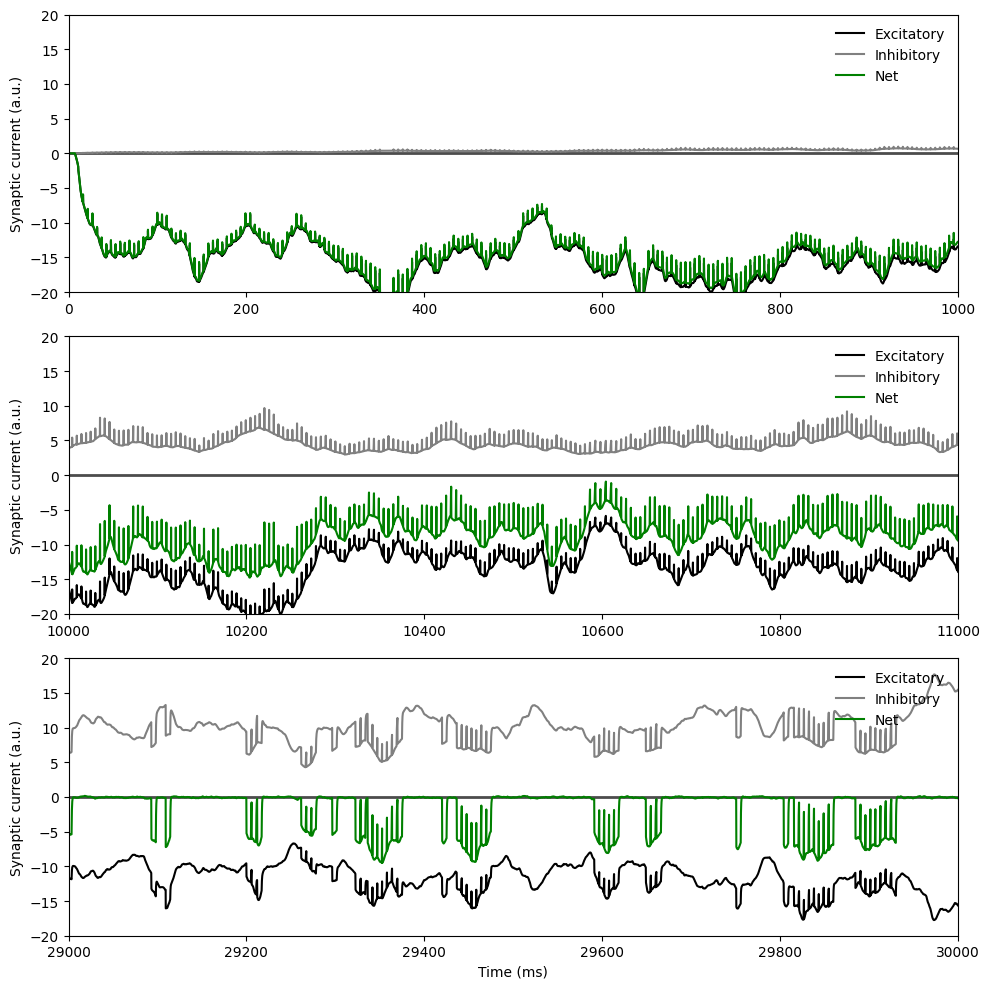

In [4]:
multimeter = nest.Create("multimeter", params={
    "record_from": ["V_m", "g_ex", "g_in"],
    "interval": 0.1  # Resolución temporal alta para ver las corrientes
})
nest.Connect(multimeter, post)

nest.Simulate(60000.0) 
events = nest.GetStatus(multimeter, "events")[0] #Obtencion de datos del multimeter

t = events["times"]
V = events["V_m"]
gE = events["g_ex"]
gI = events["g_in"]

E_ex = neuron_params["E_ex"]
E_in = neuron_params["E_in"]

I_E = gE * (-E_ex + V)
I_I = gI * (- E_in + V)
I_net = I_E + I_I

#  Definimos los 3 intervalos de tiempo de o0bservacion
intervalos = [
    (0, 1000),      # Intervalo 1
    (10000, 11000), # Intervalo 2 
    (29000, 30000)  # Intervalo 3
]
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True)

for ax, (inicio, fin) in zip(axs, intervalos):
    ax.axhline(0, color='black', linestyle='-', linewidth=2, alpha=0.7)
    ax.plot(t, I_E/1000, color="black", label="Excitatory")
    ax.plot(t, I_I/1000, color="gray", label="Inhibitory")
    ax.plot(t, I_net/1000, color="green", label="Net")
    
    ax.set_xlim(inicio, fin)
    ax.set_ylim(-20,20)
    ax.set_ylabel("Synaptic current (a.u.)")
    ax.legend(frameon=False, loc="upper right")
    
 
    #ax.set_title(f"Intervalo: {inicio} - {fin} ms")

axs[-1].set_xlabel("Time (ms)")

plt.tight_layout()
plt.show()

Conexiones listas. Tiempo de setup: 0.002752065658569336 s
Simulación terminada.


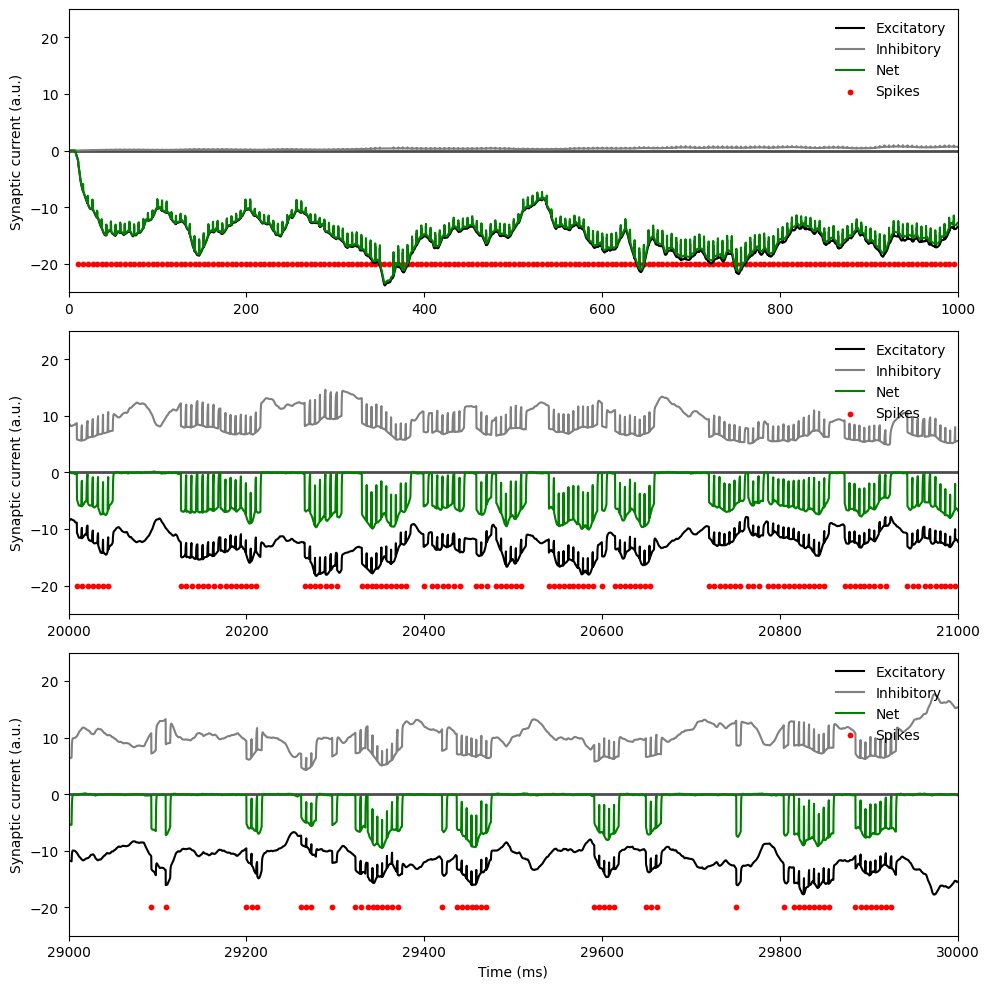

In [19]:
import nest
import matplotlib.pyplot as plt
import numpy as np
import time

# ==================== RESET NEST ====================
nest.ResetKernel()
resolution = 0.1
nest.SetKernelStatus({
    "resolution": resolution,   
    "print_time": True
})
np.random.seed(42)

# ==================== PARÁMETROS DEL MODELO ====================
neuron_params = {
    "C_m": 200.0,        # pF
    "g_L": 10.0,         # nS
    "E_L": -60.0,        # mV
    "V_th": -50.0,       # mV
    "V_reset": -60.0,    # mV
    "t_ref": 5.0,        # ms
    "E_ex": 0.0,         # mV
    "E_in": -80.0        # mV
}

tau_ex = 5.0    # ms
tau_in = 10.0   # ms

# ==================== CREAR NEURONA POSTSINÁPTICA ====================
post = nest.Create("iaf_cond_alpha", params={
    **neuron_params, 
    "tau_syn_ex": tau_ex, 
    "tau_syn_in": tau_in
})

# ==================== CONFIGURACIÓN DE GRUPOS ====================
n_groups = 8                    
N_exc_per_group = 100           
N_inh_per_group = 25           

exc_parrots = []
inh_parrots = []

for g in range(n_groups):
    exc_parrots.append(nest.Create("parrot_neuron", N_exc_per_group))
    inh_parrots.append(nest.Create("parrot_neuron", N_inh_per_group))

# ==================== GENERAR SEÑALES MODULADAS ====================
T_sim = 30000.0  # ms
dt_signal = 5.0  # ms
tau_signal = 50.0  # ms
times = np.arange(dt_signal, T_sim + dt_signal, dt_signal)
alpha = dt_signal / tau_signal

rate_mean = 10.0  # Hz
rate_std = 5.0    # Hz

signals = []
for g in range(n_groups):
    noise = np.random.randn(len(times))
    signal = np.zeros_like(noise)
    for i in range(1, len(signal)):
        signal[i] = signal[i-1] + alpha * (-signal[i-1] + noise[i])
    signal = (signal - np.mean(signal)) / np.std(signal)
    rates = rate_mean + rate_std * signal
    rates[rates < 0.1] = 0.1
    signals.append(rates)

# ==================== PESOS EXCITATORIOS ====================
preferred_group = 4
w_exc_max = 3.0
w_exc_min = 1.5

w_exc_by_group = []
for g in range(n_groups):
    if g == preferred_group:
        w_exc_by_group.append(w_exc_max)
    else:
        distance = abs(g - preferred_group)
        weight = w_exc_min + (w_exc_max - w_exc_min) * np.exp(-distance/2.0)
        w_exc_by_group.append(weight)

# ==================== GENERADORES DE POISSON ====================
exc_gens = []
inh_gens = []

for g in range(n_groups):
    exc_gen = nest.Create("inhomogeneous_poisson_generator", params={
        "rate_times": times.tolist(),
        "rate_values": signals[g].tolist(),
        "origin": 0.0,
        "start": 0.0
    })
    inh_gen = nest.Create("inhomogeneous_poisson_generator", params={
        "rate_times": times.tolist(),
        "rate_values": signals[g].tolist(),
        "origin": 0.0,
        "start": 0.0
    })
    exc_gens.append(exc_gen)
    inh_gens.append(inh_gen)

# ==================== PARÁMETROS DE SINAPSIS ====================
delay = 1.0

inh_syn_params = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight": -0.1,
    "delay": delay,
    "eta": 0.005,
    "alpha": 0.0025,
    "tau": 20.0,
    "Wmax": -200.0,
}

# ==================== CONEXIONES ====================
start_time = time.time()

for g in range(n_groups):
    nest.Connect(exc_gens[g], exc_parrots[g], conn_spec="all_to_all")
    nest.Connect(inh_gens[g], inh_parrots[g], conn_spec="all_to_all")
    nest.Connect(
        exc_parrots[g], post,
        syn_spec={
            "synapse_model": "static_synapse",
            "weight": w_exc_by_group[g],
            "delay": delay,
        })
    nest.Connect(
        inh_parrots[g], post,
        syn_spec=inh_syn_params
    )

print("Conexiones listas. Tiempo de setup:", time.time() - start_time, "s")

# ==================== MULTIMETER ====================
multimeter = nest.Create("multimeter", params={
    "record_from": ["V_m", "g_ex", "g_in"],
    "interval": 0.1
})
nest.Connect(multimeter, post)

# ==================== SPIKE RECORDER ====================
spike_recorder = nest.Create("spike_recorder")
nest.Connect(post, spike_recorder)

# ==================== SIMULACIÓN ====================
nest.Simulate(T_sim)
print("Simulación terminada.")

# ==================== DATOS DEL MULTIMETER ====================
events = nest.GetStatus(multimeter, "events")[0]
t = events["times"]
V = events["V_m"]
gE = events["g_ex"]
gI = events["g_in"]

E_ex = neuron_params["E_ex"]
E_in = neuron_params["E_in"]

I_E = gE * (-E_ex + V)
I_I = gI * (- E_in + V)
I_net = I_E + I_I

# ==================== DATOS DE SPIKES ====================
spike_events = nest.GetStatus(spike_recorder, "events")[0]
spike_times = spike_events["times"]

# ==================== INTERVALOS ====================
intervalos = [
    (0, 1000),
    (20000, 21000),
    (29000, 30000)
]

# ==================== GRAFICAR SUBPLOTS ====================
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharey=True)

for ax, (inicio, fin) in zip(axs, intervalos):
    ax.axhline(0, color='black', linestyle='-', linewidth=2, alpha=0.7)
    
    # Filtrar datos del multimeter para este intervalo
    mask = (t >= inicio) & (t <= fin)
    ax.plot(t[mask], I_E[mask]/1000, color="black", label="Excitatory")
    ax.plot(t[mask], I_I[mask]/1000, color="gray", label="Inhibitory")
    ax.plot(t[mask], I_net[mask]/1000, color="green", label="Net")
    
    # Filtrar spikes para este intervalo
    spike_mask = (spike_times >= inicio) & (spike_times <= fin)
    y_offset = -20 # ajustar según tus límites de y
    ax.scatter(spike_times[spike_mask], np.full_like(spike_times[spike_mask], y_offset), 
           color="red", s=10, label="Spikes")
    ax.set_xlim(inicio, fin)
    ax.set_ylim(-25,25)
    ax.set_ylabel("Synaptic current (a.u.)")
    ax.legend(frameon=False, loc="upper right")

axs[-1].set_xlabel("Time (ms)")
plt.tight_layout()
plt.show()


# Fig 1E (Evoked canals)

In [13]:
import nest
import numpy as np
import matplotlib.pyplot as plt

# ======================================================
# PARÁMETROS GENERALES
# ======================================================
nest.ResetKernel()
resolution = 0.1
nest.SetKernelStatus({"resolution": resolution})

np.random.seed(42)

n_groups = 8
N_exc = 100
N_inh = 25

T_learn = 300000.0   # ms  (fase de aprendizaje)
T_measure = 4000.0 # ms  (fase de medición)

# ======================================================
# NEURONA POSTSINÁPTICA (paper)
# ======================================================
neuron_params = {
    "C_m": 200.0,
    "g_L": 10.0,
    "E_L": -60.0,
    "V_th": -50.0,
    "V_reset": -60.0,
    "t_ref": 5.0,
    "E_ex": 0.0,
    "E_in": -80.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 10.0
}

post = nest.Create("iaf_cond_alpha", params=neuron_params)

# ======================================================
# PARROTS
# ======================================================
exc_parrots, inh_parrots = [], []

for g in range(n_groups):
    exc_parrots.append(nest.Create("parrot_neuron", N_exc))
    inh_parrots.append(nest.Create("parrot_neuron", N_inh))

# ======================================================
# SEÑALES OU (τ = 50 ms)
# ======================================================
dt_signal = 5.0
tau_signal = 50.0
times = np.arange(dt_signal, T_learn + dt_signal, dt_signal)
alpha = dt_signal / tau_signal

rate_mean = 10.0
rate_std = 5.0

signals = []

for g in range(n_groups):
    noise = np.random.randn(len(times))
    x = np.zeros_like(noise)

    for i in range(1, len(x)):
        x[i] = x[i-1] + alpha * (-x[i-1] + noise[i])

    x = (x - x.mean()) / x.std()
    rates = rate_mean + rate_std * x
    rates[rates < 0.1] = 0.1
    signals.append(rates)

# ======================================================
# PESOS EXCITATORIOS SINTONIZADOS
# ======================================================
preferred = 4  # canal 5 (indexado desde 0)
w_exc_max = 3.0
w_exc_min = 1.5

w_exc = []
for g in range(n_groups):
    d = abs(g - preferred)
    w = w_exc_min + (w_exc_max - w_exc_min) * np.exp(-d / 2.0)
    w_exc.append(w)

# ======================================================
# GENERADORES
# ======================================================
exc_gens, inh_gens = [], []

for g in range(n_groups):
    exc_gens.append(
        nest.Create("inhomogeneous_poisson_generator",
                    params={"rate_times": times.tolist(),
                            "rate_values": signals[g].tolist()}))
    inh_gens.append(
        nest.Create("inhomogeneous_poisson_generator",
                    params={"rate_times": times.tolist(),
                            "rate_values": signals[g].tolist()}))

# ======================================================
# CONEXIONES
# ======================================================
delay = 1.0

inh_plastic = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight": -0.1,
    "delay": delay,
    "eta": 0.001,
    "alpha": 0.02,
    "tau": 20.0,
    "Wmax": -200.0
}

for g in range(n_groups):
    nest.Connect(exc_gens[g], exc_parrots[g])
    nest.Connect(inh_gens[g], inh_parrots[g])

    nest.Connect(exc_parrots[g], post,
                 syn_spec={"weight": w_exc[g], "delay": delay})

    nest.Connect(inh_parrots[g], post, syn_spec=inh_plastic)

# ======================================================
# FASE DE APRENDIZAJE
# ======================================================
print("Aprendiendo...")
nest.Simulate(T_learn)

# ======================================================
# CONGELAR PESOS INHIBITORIOS
# ======================================================
conns = nest.GetConnections(target=post,
                            synapse_model="vogels_sprekeler_synapse")

weights = np.array(conns.get("weight"))
w_inh_frozen = np.split(weights, n_groups)

w_inh_mean = [np.mean(w) for w in w_inh_frozen]

# ======================================================
# FUNCIÓN DE MEDICIÓN (Fig 1E)
# ======================================================
def measure_channel(channel):

    nest.ResetKernel()
    nest.SetKernelStatus({"resolution": resolution})

    # neurona postsináptica
    post = nest.Create("iaf_cond_alpha", params=neuron_params)

    # tiempos SOLO para medición
    times_measure = np.arange(
        dt_signal,
        T_measure + dt_signal,
        dt_signal
    )

    exc_parrots, inh_parrots = [], []

    for g in range(n_groups):

        exc_parrots.append(nest.Create("parrot_neuron", N_exc))
        inh_parrots.append(nest.Create("parrot_neuron", N_inh))

        # conectar a la neurona postsináptica
        nest.Connect(
            exc_parrots[g], post,
            syn_spec={"weight": w_exc[g], "delay": delay}
        )

        nest.Connect(
            inh_parrots[g], post,
            syn_spec={"weight": w_inh_mean[g], "delay": delay}
        )

        # ===== señal SOLO en el canal activo =====
        if g == channel:
            rates = 5.0 + signals[g][:len(times_measure)]
        else:
            rates = np.full(len(times_measure), 5.0)

        rates[rates < 0.1] = 0.1

        # ===== 100 excitatorios independientes =====
        for n in range(N_exc):
            ge = nest.Create(
                "inhomogeneous_poisson_generator",
                params={
                    "rate_times": times_measure.tolist(),
                    "rate_values": rates.tolist()
                }
            )
            nest.Connect(ge, exc_parrots[g][n])

        # ===== 25 inhibitorios independientes =====
        for n in range(N_inh):
            gi = nest.Create(
                "inhomogeneous_poisson_generator",
                params={
                    "rate_times": times_measure.tolist(),
                    "rate_values": rates.tolist()
                }
            )
            nest.Connect(gi, inh_parrots[g][n])

    # ===== multimeter =====
    mm = nest.Create(
        "multimeter",
        params={
            "record_from": ["V_m", "g_ex", "g_in"],
            "interval": resolution
        }
    )
    nest.Connect(mm, post)

    nest.Simulate(T_measure)

    ev = mm.get("events")
    V = ev["V_m"]
    gE = ev["g_ex"]
    gI = ev["g_in"]

    I_ex = gE * (neuron_params["E_ex"] - V)
    I_in = -gI * (neuron_params["E_in"] - V)

    return np.mean(I_ex), np.mean(I_in)


# ======================================================
# MEDICIÓN FINAL
# ======================================================
Iex, Iin = [], []

for g in range(n_groups):
    ie, ii = measure_channel(g)
    Iex.append(ie)
    Iin.append(ii)



Aprendiendo...


In [ ]:
import nest
import numpy as np
import matplotlib.pyplot as plt

# ======================================================
# PARÁMETROS GENERALES
# ======================================================
nest.ResetKernel()
resolution = 0.1
nest.SetKernelStatus({"resolution": resolution})
np.random.seed(42)

n_groups = 8
N_exc = 100
N_inh = 25

T_learn = 300000.0   # ms de aprendizaje
T_measure = 4000.0   # ms de medición por snapshot
delay = 1.0

# ======================================================
# NEURONA POSTSINÁPTICA
# ======================================================
neuron_params = {
    "C_m": 200.0,
    "g_L": 10.0,
    "E_L": -60.0,
    "V_th": -50.0,
    "V_reset": -60.0,
    "t_ref": 5.0,
    "E_ex": 0.0,
    "E_in": -80.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 10.0
}

post = nest.Create("iaf_cond_alpha", params=neuron_params)

# ======================================================
# PARROTS
# ======================================================
exc_parrots, inh_parrots = [], []
for g in range(n_groups):
    exc_parrots.append(nest.Create("parrot_neuron", N_exc))
    inh_parrots.append(nest.Create("parrot_neuron", N_inh))

# ======================================================
# SEÑALES OU
# ======================================================
dt_signal = 5.0
tau_signal = 50.0
times = np.arange(dt_signal, T_learn + dt_signal, dt_signal)
alpha = dt_signal / tau_signal
rate_mean = 10.0
rate_std = 5.0

signals = []
preferred = 4  # canal preferido

for g in range(n_groups):
    noise = np.random.randn(len(times))
    x = np.zeros_like(noise)
    for i in range(1, len(x)):
        x[i] = x[i-1] + alpha * (-x[i-1] + noise[i])
    x = (x - x.mean()) / x.std()
    
    # Señal amplificada para canal preferido
    if g == preferred:
        rates = rate_mean + 1.5 * rate_std * x
    else:
        rates = rate_mean + rate_std * x
    rates[rates < 0.1] = 0.1
    signals.append(rates)

# ======================================================
# PESOS EXCITATORIOS
# ======================================================
w_exc_max = 3.0
w_exc_min = 1.5
w_exc = []
for g in range(n_groups):
    d = abs(g - preferred)
    w_exc.append(w_exc_min + (w_exc_max - w_exc_min) * np.exp(-d/2.0))

# ======================================================
# INHIBICIÓN PLÁSTICA
# ======================================================
inh_plastic = {
    "synapse_model": "vogels_sprekeler_synapse",
    "weight": -0.1,
    "delay": delay,
    "eta": 0.0005,
    "alpha": 0.02,
    "tau": 20.0,
    "Wmax": -200.0
}

# ======================================================
# APRENDIZAJE CON GENERADORES INDEPENDIENTES
# ======================================================
print("Aprendiendo...")

for g in range(n_groups):
    # excitatorios independientes
    for n in range(N_exc):
        ge = nest.Create("inhomogeneous_poisson_generator",
                         params={"rate_times": times.tolist(),
                                 "rate_values": (5.0 + signals[g]).tolist()})
        nest.Connect(ge, exc_parrots[g][n])
    
    # inhibitorios independientes
    for n in range(N_inh):
        gi = nest.Create("inhomogeneous_poisson_generator",
                         params={"rate_times": times.tolist(),
                                 "rate_values": (5.0 + signals[g]).tolist()})
        nest.Connect(gi, inh_parrots[g][n])
    
    # conectar parrot -> post
    nest.Connect(exc_parrots[g], post, syn_spec={"weight": w_exc[g], "delay": delay})
    nest.Connect(inh_parrots[g], post, syn_spec=inh_plastic)

nest.Simulate(T_learn)

# ======================================================
# CONGELAR PESOS INHIBITORIOS
# ======================================================
conns = nest.GetConnections(target=post, synapse_model="vogels_sprekeler_synapse")
weights = np.array(conns.get("weight"))
w_inh_frozen = np.split(weights, n_groups)
w_inh_mean = [np.mean(w) for w in w_inh_frozen]

# ======================================================
# FUNCIÓN DE MEDICIÓN CON SNAPSHOTS
# ======================================================
def measure_snapshot(T_measure, channel):
    post_snap = nest.Create("iaf_cond_alpha", params=neuron_params)
    t0 = nest.GetKernelStatus()['time']
    times_measure = t0 + np.arange(dt_signal, T_measure + dt_signal, dt_signal)

    exc_parrots_snap, inh_parrots_snap = [], []
    
    for g in range(n_groups):
        exc_parrots_snap.append(nest.Create("parrot_neuron", N_exc))
        inh_parrots_snap.append(nest.Create("parrot_neuron", N_inh))
        
        nest.Connect(exc_parrots_snap[g], post_snap, syn_spec={"weight": w_exc[g], "delay": delay})
        nest.Connect(inh_parrots_snap[g], post_snap, syn_spec={"weight": w_inh_mean[g], "delay": delay})
        
        if g == channel:
            rates = 5.0 + signals[g][:len(times_measure)]
        else:
            rates = np.full(len(times_measure), 5.0)
        
        for n in range(N_exc):
            ge = nest.Create("inhomogeneous_poisson_generator",
                             params={"rate_times": times_measure.tolist(),
                                     "rate_values": rates.tolist()})
            nest.Connect(ge, exc_parrots_snap[g][n])
        
        for n in range(N_inh):
            gi = nest.Create("inhomogeneous_poisson_generator",
                             params={"rate_times": times_measure.tolist(),
                                     "rate_values": rates.tolist()})
            nest.Connect(gi, inh_parrots_snap[g][n])
    
    mm = nest.Create("multimeter", params={"record_from":["V_m","g_ex","g_in"], "interval": resolution})
    nest.Connect(mm, post_snap)
    
    nest.Simulate(T_measure)
    
    ev = mm.get("events")
    V = ev["V_m"]
    gE = ev["g_ex"]
    gI = ev["g_in"]
    
    I_ex = gE * (neuron_params["E_ex"] - V)
    I_in = -gI * (neuron_params["E_in"] - V)
    
    return np.mean(I_ex), np.mean(I_in)

# ======================================================
# MEDICIÓN SNAPSHOTS: inicio / mitad / final
# ======================================================
snapshots = [0, int(T_learn/2), int(T_learn-4000)]
Iex_snap, Iin_snap = [], []

for t_snap in snapshots:
    nest.Simulate(t_snap - nest.GetKernelStatus()['time'])  # avanzar hasta snapshot
    Iex, Iin = [], []
    for g in range(n_groups):
        ie, ii = measure_snapshot(T_measure, g)
        Iex.append(ie)
        Iin.append(ii)
    Iex_snap.append(Iex)
    Iin_snap.append(Iin)

# ======================================================
# PLOT
# ======================================================
fig, axs = plt.subplots(1,3, figsize=(15,4))
labels = ["Inicio", "Mitad", "Final"]

x = np.arange(1, n_groups+1)
for i in range(3):
    axs[i].plot(x, Iex_snap[i], 'ko-', label="Excitatory")
    axs[i].plot(x, Iin_snap[i], 'wo-', markeredgecolor='k', label="Inhibitory")
    axs[i].axhline(0, color='black', lw=0.8)
    axs[i].set_title(labels[i])
    axs[i].set_xlabel("Signal channel #")
    axs[i].set_ylabel("Mean synaptic current (pA)")
    axs[i].legend(frameon=False)
plt.tight_layout()
plt.show()


Aprendiendo...


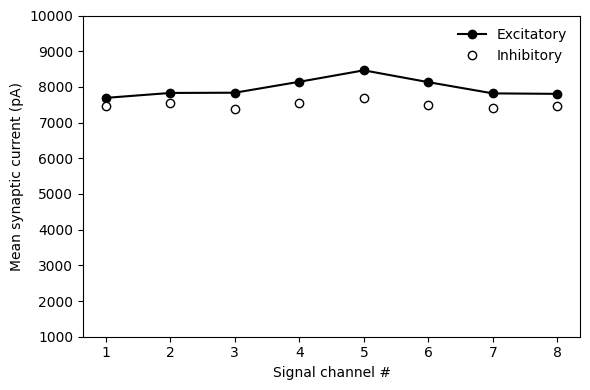

In [12]:
# ======================================================
# PLOT — Fig. 1E
# ======================================================
x = np.arange(1, n_groups + 1)

plt.figure(figsize=(6,4))
plt.plot(x, Iex, 'ko-', label="Excitatory")
plt.plot(x, Iin, 'wo-', markeredgecolor='k', label="Inhibitory")
plt.axhline(0, color='black', lw=0.8)
plt.xlabel("Signal channel #")
plt.ylabel("Mean synaptic current (pA)")
plt.ylim(1000,10000)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

Aprendiendo...


KeyError: 'time'